# Data Exploration

I want to see what the pdb files data actually looks like and figure out how to read it effectively, my intuition is that they will be difficult to read because they contain a variety of different data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import ipywidgets as ip
from matplotlib import pyplot as plt
import os
import utils
from fastai import *
import matplotlib
import seaborn as sns
from tqdm import tqdm
from collections import Counter as cs
import nglview as nv
import sys
from sklearn.model_selection import train_test_split
%matplotlib inline

Using TensorFlow backend.


In [3]:
import Bio.PDB as bio
import warnings
warnings.filterwarnings("ignore")

In [4]:
plt.rcParams['figure.figsize'] = [16,6]

## Read Data

In [5]:
data_path = os.curdir + '/data/'
pdb_path = os.curdir + '/data/pdb/structures/pdb/'
pdb_list = next(os.walk(pdb_path))[2]

In [6]:
#load sequence file as a bcolz array for the sake of space and speed
seq_file = load_array(data_path+'sequences.bc')
#seq = np.array(open(data_path + 'pdb_seqres.txt').readlines())

In [7]:
residue_letter_codes = {'GLY': 'G','PRO': 'P','ALA': 'A','VAL': 'V','LEU': 'L',
                        'ILE': 'I','MET': 'M','CYS': 'C','PHE': 'F','TYR': 'Y',
                        'TRP': 'W','HIS': 'H','LYS': 'K','ARG': 'R','GLN': 'Q',
                        'ASN': 'N','GLU': 'E','ASP': 'D','SER': 'S','THR': 'T'}

In [8]:
def create_targets(pdb_file_path, residue_letter_codes):
    p = bio.PDBParser()
    s = p.get_structure('X', pdb_file_path)
    
    #randomly select one model from the pdb file
    gen = s.get_models()
    l = list(gen)
    mod = l[np.random.randint(0, len(l))]
    
    chain_coords=[]
    seq_strs = []
    seq_locs = []
    
    #for model in s:
    for chain in mod:
        seq_str = ''
        seq_loc = []
        coords = []
        for ix,residue in enumerate(chain):
            if residue.get_id()[0] == ' ':
                for atom in residue:
                    if atom.get_name() == "N":
                        n = atom.get_coord()
                    elif atom.get_name() == "CA":
                        ca = atom.get_coord()
                    elif atom.get_name() == "C":
                        cp = atom.get_coord()
                try: #in some cases N is missing on the first residue, so we append zeros instead
                    #print(np.stack([n,ca,cp]))
                    coords.append(np.stack([n,ca,cp], axis=0))
                    letter_code = residue_letter_codes[residue.get_resname()]
                    #del n, ca, cp
                except:
                    #first[-1] += 1 move past the first residue and ignore it
                    pass
                else:
                    seq_str += letter_code
                    seq_loc.append(atom.get_full_id()[3][1])

        chain_coords.append(coords)
        seq_strs.append(seq_str)
        seq_locs.append(np.unique(seq_loc))
        
    return chain_coords, seq_strs, seq_locs

In [9]:
def parse_pdb(pdb_file, residue_letter_codes):
    #pdb_file = 'pdb5l6t.ent' #np.random.choice(pdb_list)
    p = bio.PDBParser()
    s = p.get_structure('X', pdb_path+pdb_file)
    
    gen = s.get_models()
    l = list(gen)
    mod = l[np.random.randint(0, len(l))] #choose random model when more than 1 exists
    
    seq_strs = []
    seq_locs = []
    for chain in mod:
        seq_str = ''
        seq_loc = []
        for residue in chain:
            if residue.get_id()[0] == ' ':
                letter_code = residue_letter_codes[residue.get_resname()]
                seq_str += letter_code
                for atom in residue:
                    seq_loc.append(atom.get_full_id()[3][1])
        seq_strs.append(seq_str)
        seq_locs.append(np.unique(seq_loc))
        
    return seq_strs, seq_locs

In [10]:
def align_indices(seq_strs, seq_locs, gt_seq, start_match_length=5):
    fill_indices = []
    for ix, pdb_seq in enumerate(seq_strs):
        search_seq = gt_seq[ix]
        pos = np.core.defchararray.find(search_seq, pdb_seq[:start_match_length])
        if pos < 0:
            raise ValueError('First 5 residues in pdb file have no match!')
        locs = seq_locs[ix] + (pos - seq_locs[ix][0])
        fill_indices.append(np.intersect1d(range(len(search_seq)), locs))
    
    return fill_indices

In [147]:
chain_coords, seq_strs, seq_locs = \
    create_targets(pdb_path+'pdb3oaz.ent', residue_letter_codes)
gt_seq = utils.gather_sequence('3oaz', seq_file)

In [154]:
align_indices(seq_strs, seq_locs, gt_seq)

0
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 155 156 161 162 163 164 165 166 167 168
 170 171 172 173 174 175 176 177 178 179 181 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 196 197 198 199 202 204 205 206 207 208 209
 210 211 212 213 214 215 216 217 218 219 220 221 224 225 226]
-1


ValueError: First 5 residues in pdb file have no match!

In [10]:
#fill_indices = []
#for ix, pdb_seq in enumerate(seq_strs):
#    search_seq = gt_seq[ix]
#    pos = np.core.defchararray.find(search_seq, pdb_seq[:5])
#    locs = seq_locs[ix] + (pos - seq_locs[ix][0])
#    fill_indices.append(np.setdiff1d(range(len(search_seq)), locs))

In [11]:
#test_file = np.random.choice(pdb_list)
#print(test_file)
#main error I run into is unusual residues (or UNK) as in pdb3v6t.ent
#not in this step, but later, also many have no N, C or CA atoms in residue
#errors=0
#for f in tqdm(pdb_list[:500]):
#    test_file = f
#    try:
#        seq_strs, seq_locs = parse_pdb(test_file, residue_letter_codes)
#        gt_seq = utils.gather_sequence(test_file[3:7], seq_file)
#        fill_indices = align_indices(seq_strs, seq_locs, gt_seq)
#    except:
#        errors += 1
#        pass
#in first 500 samples, there are only 36 errors

Below accomplishes the goal of finding the correct starting point and comparing the position of each residue in the PDB sequence to the ground truth FASTA sequence. Using an array of those positions and determining the set difference with an unbroken sequence, we can find gaps in the pdb sequence. Currently, there are two more things left to do:
<ul>
    <li>Repeated residues in the gt sequence could throw of the index by a couple of residues, after every break, I need to again align a sequence of 5 or so residues to almost guarentee that I have the correct gap indices.</li>
    <li>Fill gaps with 'x' and totally eliminate pdb files with weird modified residues like CSX or selenomethionine, etc.</li>
</ul>

In [154]:
#search_seq = gt_seq[1]
#pdb_seq = seq_strs[1]
#set_idx=[]
#pos = np.core.defchararray.find(search_seq, pdb_seq[:5])
#set_idx.append(pos)
#x_seq = 'x'*set_idx[-1].tolist() + pdb_seq[0] #pad start with x

#for ix, res in enumerate(pdb_seq[1:]):
#    pos = np.core.defchararray.find(search_seq, res, start=pos+1)
#    if pos == set_idx[-1]+1:
#        x_seq += res
#    else:
#        x_seq += ('x'*(pos.tolist()-set_idx[-1].tolist()-1) + res)   
#    set_idx.append(pos)
#missing_res = np.setdiff1d(range(len(search_seq)), set_idx)

In [155]:
#ids=[]
#for line in seq[::2]:
#    ids.append(line[1:5])
#pdb_ids=[]
#for f in pdb_list:
#    pdb_ids.append(f[3:7])
#msk = np.in1d(ids, pdb_ids)
#s = seq[np.repeat(msk,2)]
#save_array(data_path+'sequences.bc', s)

In [156]:
#for ix, pdb_file in tqdm(enumerate(pdb_list[4300:5000])):
#    pdb_id = pdb_file[3:7]
    #sequence = utils.gather_sequence(pdb_id, seq_file)
#    coords, chains, first, last = utils.create_targets(pdb_path+pdb_file)
#    out = np.array([np.reshape(c, (-1,3)) for c in coords])

#    if out.shape[0] == 0:
        #print(ix, pdb_file)
#        break

In [157]:
#out = np.array([np.reshape(c, (-1,3)) for c in coords])
#zt = np.array([sequence, first, last, out.squeeze()])

In [95]:
pdb_file = 'pdb5l6t.ent'
pdb_id = pdb_file[3:7]

gt_seq = utils.gather_sequence(pdb_id, seq_file)
chain_coords, seq_strs, seq_locs = create_targets(pdb_path+pdb_file, residue_letter_codes)
fill_indices = align_indices(seq_strs, seq_locs, gt_seq, 5)

#TODO: maybe add option for other fill values?
empty = [np.zeros((len(seq), 3, 3)) for seq in gt_seq]

for chain_ix, chain in enumerate(fill_indices):
    for pos, index in enumerate(chain):
        empty[chain_ix][index] = chain_coords[chain_ix][pos]

out = np.array([np.reshape(c, (-1,3)) for c in empty])
out

array([[[  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        ..., 
        [ 38.31000137,   4.08400011,  10.6420002 ],
        [ 38.29299927,   4.65999985,   9.25500011],
        [ 37.47200012,   5.95699978,   9.1079998 ]],

       [[  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        ..., 
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ]]])

In [18]:
def make_carrays(pdb_path, pdb_list, seq_file, 
                 residue_letter_codes, max_chains=8, save=False, 
                 save_path=None):
    
    out_lengths=[]
    errors = 0
    saved = 0
    for pdb_file in tqdm(pdb_list):
        pdb_id = pdb_file[3:7]
        
        gt_seq = utils.gather_sequence(pdb_id, seq_file)
        chain_coords, seq_strs, seq_locs = create_targets(pdb_path+pdb_file, residue_letter_codes)
        try:
            fill_indices = align_indices(seq_strs, seq_locs, gt_seq, 5)
        except:
            errors += 1
            continue
        
        #TODO: maybe add option for other fill values?
        empty = [np.zeros((len(seq), 3, 3)) for seq in gt_seq]
        
        for chain_ix, chain in enumerate(fill_indices):
            for pos, index in enumerate(chain):
                empty[chain_ix][index] = chain_coords[chain_ix][pos]
        
        out = np.array([np.reshape(c, (-1,3)) for c in empty])

        if len(out) <= max_chains: #exclude proteins with too many chains
            if len(out) == 1:
                zt = np.array([[pdb_id], gt_seq, out.squeeze()])
            elif len(out.shape) > 1:
                #causes errors because of abitrary shapes
                zt = np.array([[pdb_id], gt_seq, [out]])
            else:
                zt = np.array([[pdb_id], gt_seq, out])

            #if len(zt) < 3:
            #    print(pdb_id)
            #    break
            
            if save:
                saved += 1
                if len(out) in out_lengths:
                    bc = bcolz.carray(
                        rootdir=save_path+'proteins_{}.bc'.format(len(out)), mode='w'
                    )
                    bc.append([zt])
                    bc.flush()
                else:
                    bc = bcolz.carray(
                        [zt], rootdir=save_path+'proteins_{}.bc'.format(len(out)), mode='w'
                    )
                    bc.flush()
                    out_lengths.append(len(out))
                    
        if saved == 5000:
            break
            
    return 'Errors: {}, Total saved: {}'.format(errors, saved)

In [19]:
make_carrays(pdb_path, pdb_list, seq_file, residue_letter_codes, 
            max_chains=8, save=True, save_path=data_path)

 18%|█▊        | 5954/33654 [3:17:04<15:16:52,  1.99s/it]

'Errors: 867, Total saved: 5000'

In [36]:
chain_1 = load_array(data_path+'proteins_8.bc')

78

In [29]:
utils.gather_sequence('5t1u', seq_file)

['ETDEEPEEPGRRGSFVEMVDNLRGKSGQGYYVEMTVGSPPQTLNILVDTGSSNFAVGAAPHPFLHRYYQRQLSSTYRDLRKGVYVPYTQGKWEGELGTDLVSIPHGPNVTVRANIAAITESDKFFINGSNWEGILGLAYAEIARPDDSLEPFFDSLVKQTHVPNLFSLQLCGAGFPLNQSEVLASVGGSMIIGGIDHSLYTGSLWYTPIRREWYYEVIIVRVEINGQDLKMDCKEYNYDKSIVDSGTTNLRLPKKVFEAAVKSIKAASSTEKFPDGFWLGEQLVCWQAGTTPWNIFPVISLYLMGEVTNQSFRITILPQQYLRPVEDVATSQDDCYKFAISQSSTGTVMGAVIMEGFYVVFDRARKRIGFAVSACHVHDEFRTAAVEGPFVTLDMEDCGYNIPQTDESTHHHHHH']

In [31]:
out_lengths=[]

for ix, pdb_file in tqdm(enumerate(pdb_list[:5000])):
    
    pdb_id = pdb_file[3:7]
    
    sequence = utils.gather_sequence(pdb_id, seq_file)
    coords, chains, first, last = utils.create_targets(pdb_path+pdb_file)
    
    out = np.array([np.reshape(c, (-1,3)) for c in coords])
    
    if len(out) < 9: #exclude proteins with too many chains
        if len(out) == 1:
            zt = np.array([[pdb_id], sequence, first, last, out.squeeze()])
        elif len(out.shape) > 1:
            #causes errors because of abitrary shapes
            zt = np.array([[pdb_id], sequence, first, last, [out]])
        else:
            zt = np.array([[pdb_id], sequence, first, last, out])
        
        if len(zt) < 4:
            break
        
        #if len(out) in out_lengths:
        #    bc = bcolz.carray(rootdir=data_path+'proteins_{}.bc'.format(len(out)), mode='w')
        #    bc.append([zt])
        #    bc.flush()
        #else:
        #    bc = bcolz.carray([zt], rootdir=data_path+'proteins_{}.bc'.format(len(out)), mode='w')
        #    bc.flush()
        #    out_lengths.append(len(out))

5000it [2:40:54,  1.93s/it]


In [32]:
test1 = load_array(data_path+'proteins_1.bc')

I really don't care about the names of molecules, the only things that should matter are sequence, bonding site type, measurement technique, and atom coordinates.

## Sequence Statistics

The seq_res file is ordered with one line that gives the protein name and length and then the next line gives the sequence. I don't know exactly what the CASP data will look like so it might be useful to look at the protein description as well to make predictions.

In [9]:
#get the lengths from each line
lengths=[]
#get every other line, i.e. just the descriptions
for line in seq_file[::2]:
    loc = np.core.defchararray.find(line,'protein length:') + \
          len('protein length:')
    tail = np.core.defchararray.find(line, ' ', start=loc)
    try:
        length = np.uint16(line[loc:tail])
        lengths.append(length)
    except:
        #just skip annoying errors, corpus so large it shouldn't matter
        pass
l = np.array(lengths)
del lengths

Let's check out the distribution of lengths (there are 400,000!)

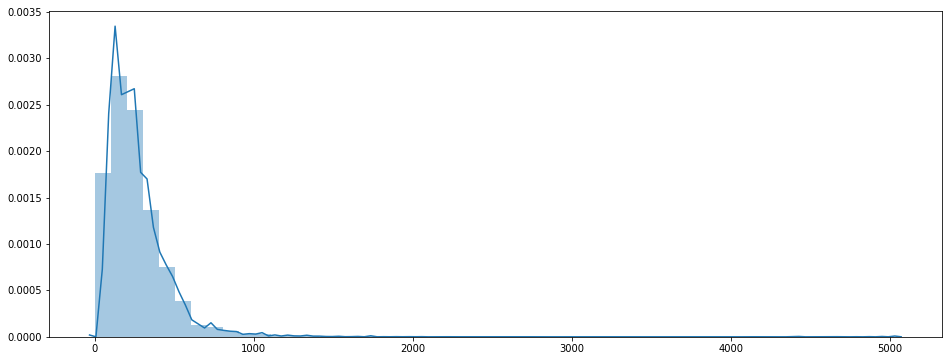

In [10]:
sns.distplot(l)

In [11]:
#basic descriptive stats
scipy.stats.describe(l)

DescribeResult(nobs=415153, minmax=(2, 5037), mean=254.33927973542285, variance=44912.030895747645, skewness=5.4375074287301475, kurtosis=80.90629011753249)

In [12]:
#maybe get counts by type (i.e. MYOGLOBIN, superoxide dismutase)

<strong>Notes:</strong>

Proteins with the same names but different sequences are probably from different animals as PDB does not just store human protein data.

What kinds of proteins are in the pdb sequence file? Are there 3D structures for all of them? How reliable are they? Cursory glance at some lines showed that the many share the same prefixes, how different are the sequences?

Check how length of sequences affects protein folding, what kind of long range interactions exist? How effective are current technqiues for handling different sequence lengths.

In [13]:
res_freq = cs()
for line in seq_file[1::2]: #just the odd line numbers
    res_freq += cs(line)

<strong>Amino acid conversion</strong>

alanine - ala - A
arginine - arg - R
asparagine - asn - N
aspartic acid - asp - D
cysteine - cys - C
glutamine - gln - Q
glutamic acid - glu - E
glycine - gly - G
histidine - his - H
isoleucine - ile - I
leucine - leu - L
lysine - lys - K
methionine - met - M
phenylalanine - phe - F
proline - pro - P
serine - ser - S
threonine - thr - T
tryptophan - trp - W
tyrosine - tyr - Y
valine - val - V

Sometimes it is not possible two differentiate two closely related amino acids:
asparagine/aspartic acid - asx - B
glutamine/glutamic acid - glx - Z

    O is a rare exception found in some bacteria and archea

In [14]:
aa = []
ct = []
for a,b in res_freq.iteritems():
    if a != '/n':
        aa.append(a)
        ct.append(b)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


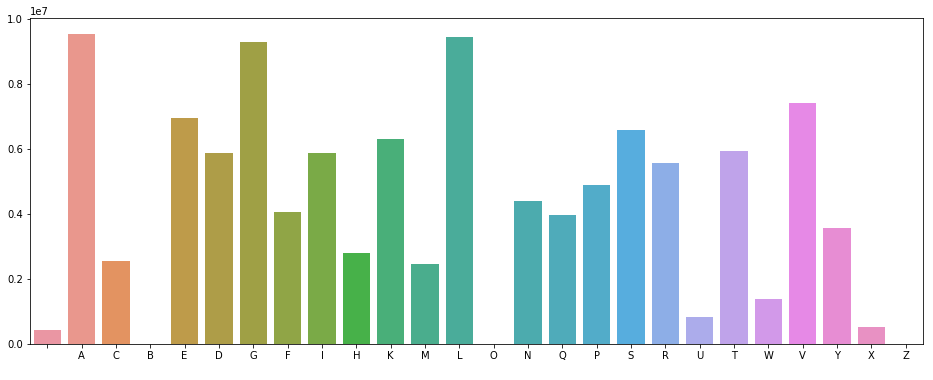

In [15]:
sns.barplot(aa, ct)

Alanine, glycine, and leucine (A, G, L) are considerably more frequent than other residues. Need to research if that distributions is skewed at all by species or kingdom. For humans, Alanine is apparently only slightly less frequent than leucine, so it probably does matter somewhat. Only about 7 residues occur less than a million times. They might be difficult to train embeddings for because of their rarity. Otherwise the distribution of residues seems well-balanced.

## PDB

In [150]:
pdb_id = '117e'
pdb_file = pdb_path + 'pdb'+pdb_id+'.ent'

In [161]:
view = nv.show_file(pdb_file)
#view = nv.show_pdbid("5yh0")
#view.clear_representations()
#view.add_representation(repr_type='cartoon')
view.background='black'
#view

In [62]:
#more than one view per cell
#view1 = nv.show_file(pdb_file)
#view1.clear_representations()
#view1.add_representation(repr_type='cartoon')
#view2 = nv.show_file(pdb_file)
#view2.clear_representations()
#view2. add_representation(repr_type='ball+stick')
#vbox = ip.VBox([view1, view2])

In [152]:
#get sequences and corresponding chain ids
def gather_sequence(pdb_id, seq_file):
    seqs=[]
    chains=[]
    #get line numbers of pdb_id
    for ix, line in enumerate(seq_file):
        pos = np.core.defchararray.find(line, pdb_id)
        if pos > 0:
            seqs.append(seq_file[ix+1][:-1]) #cut off newline character
            chains.append(line[pos+5]) #gives the chain letter from the line        
        
    return zip(chains,seqs)

In [153]:
x = gather_sequence(pdb_id, seq_file)

I was able to keep over 33,000 protein structure files, which is roughly a quarter of the entire pdb. For prototyping, I want to pick a random subset of those structures and create a new sequence file. Let's start with roughly 2,000 structures for sample train set, 500 for sample validation set, and 500 for sample test set.

In [182]:
c = np.random.choice(pdb_list, 3000)
u = np.unique(c)

msk = np.random.random(len(u)) < 0.66
trn_samp = u[msk]
t_samp = u[~msk]

psk = np.random.random(len(t_samp)) > 0.5
val_samp = t_samp[psk]
tst_samp = t_samp[~psk]

In [190]:
save_array(data_path+'train_samples.dat', trn_samp)
save_array(data_path+'validation_samples.dat', val_samp)
save_array(data_path+'test_samples.dat', tst_samp)

In [191]:
trn_samp = load_array(data_path+'train_samples.dat')
val_samp = load_array(data_path+'validation_samples.dat')
tst_samp = load_array(data_path+'test_samples.dat')